In [62]:
from collections import defaultdict
import os

import keras
import keras.backend as K
from keras.models import Model
from PIL import Image
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import core
from core.cam import overlay_gradcam
from core.fine_model import FineModel
import cr_interface as cri
from cr_interface import CrCollection

## Load data, model, results

In [3]:
model_key = "vgg16"
test_model = FineModel.get_dict()[model_key]()
test_model.load_weights("D00_FINAL")

Loading model vgg16... complete!
Loading weights from /Users/itsnamgyu/code/cardiac-research/experiments/deep_a0/output/vgg16/D00_FINAL/trained_weights.hd5...
Weights loaded


## Load data (with truth, predictions, np image, etc)

In [6]:
CLASS_INDICES = {
    "in": 0,
    "oap": 1,
    "obs": 2
}

def compile_data(collection: CrCollection, result: core.result.Result, model: FineModel, generate_cam=False):
    """Load all image, prediction data in one dictionary.
    {
        <cr_code>: {
            image: ndarray,
            truth: string,
            prediction: string,
            confidence: float,
            cam?: ndarray 
        },
    }
    """
    def _format_results(result: core.result.Result):
        d = defaultdict(dict)
        for cr_code, prediction in result.data['predictions'].items():
            predicted = prediction["prediction"]
            d[cr_code]["truth"] = prediction["truth"]
            d[cr_code]["prediction"] = predicted
            d[cr_code]["confidence"] = prediction["percentages"][predicted]
        return d
        
    def _add_cams(data):
        print("Generating CAMs")
        for cr_code, d in tqdm(data.items()):
            image = np.array(d["image"])
            class_index = CLASS_INDICES[d["prediction"]]
            cam = overlay_gradcam(model, image, class_index=class_index)
            d["cam"] = cam
    
    data = _format_results(result)
    # Add image fields
    images = collection.load_images(target_size=model.output_shape)
    for i, cr_code in enumerate(collection.get_cr_codes()):
        data[cr_code]["image"] = np.array(images[i])
        
    # Add cam (takes some time)
    if generate_cam:
        _add_cams(data)

    return dict(data)

In [7]:
# Load data, results
test_collection = CrCollection.load().filter_by(dataset_index=1)
test_result = core.result.Result.load(model_key=model_key, instance_key="D00_FINAL")
data = compile_data(test_collection, test_result, test_model)

/Users/itsnamgyu/code/cardiac-research/cr_interface.py:181: UserWarning: Loading more than 32 images
  warnings.warn('Loading more than 32 images')


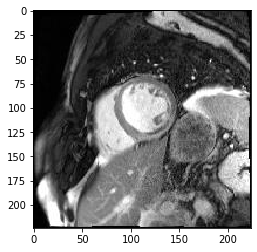

In [271]:
code0 = "D01_P00000401_P00_S09"
image0 = data[code0]["image"]
plt.imshow(image0)

## Get feature maps and feature map weights

### Image Preprocessing

In [272]:
def extract_featuremaps(model, datagen, image):
    image = image.reshape((1,) + image.shape)
    augmented = next(datagen.flow(image, shuffle=False, seed=0))
    return model.predict(augmented)


def preprocess_image(datagen, image):
    image = image.reshape((1,) + image.shape)
    augmented = next(datagen.flow(image, shuffle=False, seed=0))
    return augmented

datagen = test_model.get_image_data_generator(augment=False)

In [273]:
# Assert that model prediction method is same as initial experiment
augmented = preprocess_image(datagen, image0)
prediction = test_model.get_model().predict(augmented)
confidence = max(*list(prediction))
recorded_confidence = float(data[code0]["confidence"])

assert(abs(confidence - recorded_confidence) < 1.0e-6)
print("Success! Image preprocessing pipeline (likely) matches with experiment!")

Success! Image preprocessing pipeline (likely) matches with experiment!


In [274]:
def get_feature_maps_and_weights(model, seed_input, class_index, layer_idx=None):
    # Based on code from keras-vis by github.com/raghakot
    
    from vis.visualization.saliency import _find_penultimate_layer
    from vis.losses import ActivationMaximization
    from vis.optimizer import Optimizer 
    
    if layer_idx is None:
        layer_idx = len(model.layers) - 1
        
    filter_indices = [class_index]
    input_tensor = model.input
    # `ActivationMaximization` outputs negative gradient values for increase in activations. Multiply with -1
    # so that positive gradients indicate increase instead.
    losses = [
        (ActivationMaximization(model.layers[layer_idx], [class_index]), -1)
    ]
    penultimate_layer = _find_penultimate_layer(model, layer_idx, None)
    grad_modifier = None
    
    penultimate_output = penultimate_layer.output
    opt = Optimizer(input_tensor, losses, wrt_tensor=penultimate_output, norm_grads=False)
    _, grads, penultimate_output_value = opt.minimize(seed_input, max_iter=1, grad_modifier=grad_modifier, verbose=False)

    # For numerical stability. Very small grad values along with small penultimate_output_value can cause
    # w * penultimate_output_value to zero out, even for reasonable fp precision of float32.
    grads = grads / (np.max(grads) + K.epsilon())

    # Average pooling across all feature maps.
    # This captures the importance of feature map (channel) idx to the output.
    channel_idx = 1 if K.image_data_format() == 'channels_first' else -1
    other_axis = np.delete(np.arange(len(grads.shape)), channel_idx)
    weights = np.mean(grads, axis=tuple(other_axis))
    
    return penultimate_output_value, weights

In [275]:
raw_test_model = test_model.get_model()
predicted_class = CLASS_INDICES[data[code0]["prediction"]]
preprocessed = preprocess_image(datagen, image0)
maps, weights = get_feature_maps_and_weights(test_model.get_model(), preprocessed, predicted_class)

In [276]:
values = maps.mean(axis=(0, 1, 2))

map_data = []
for index, value in enumerate(values):
    d = {}
    d["index"] = index
    d["cr_code"] = code0 
    d["value"] = value  # global average pooled mean
    d["weight"] = weights[index]  # contribution to prediction
    d["map"] = maps[0,:,:,index]
    map_data.append(d)

### Strongest featuremaps

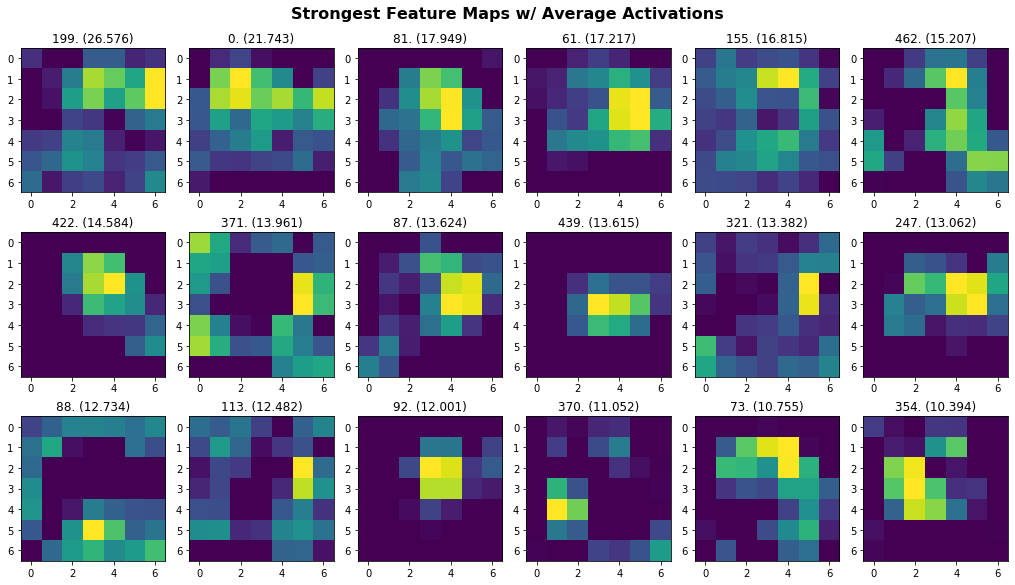

In [277]:
fig = mpl.figure.Figure(figsize=(14, 8), constrained_layout=True)
axes = fig.subplots(3, 6)
axes = axes.flatten()
top_maps = sorted(map_data, key=lambda d: d["value"], reverse=True)
for i, ax in enumerate(axes):
    ax.imshow(top_maps[i]["map"])
    ax.set_title("{}. ({:.3f})".format(top_maps[i]["index"], top_maps[i]["value"]))
fig.suptitle("Strongest Feature Maps w/ Average Activations", fontweight="bold", fontsize=16)
fig.savefig("[{}] Strongest Feature Maps.png".format(code0, dpi=320))
fig

### Weakest featuremaps

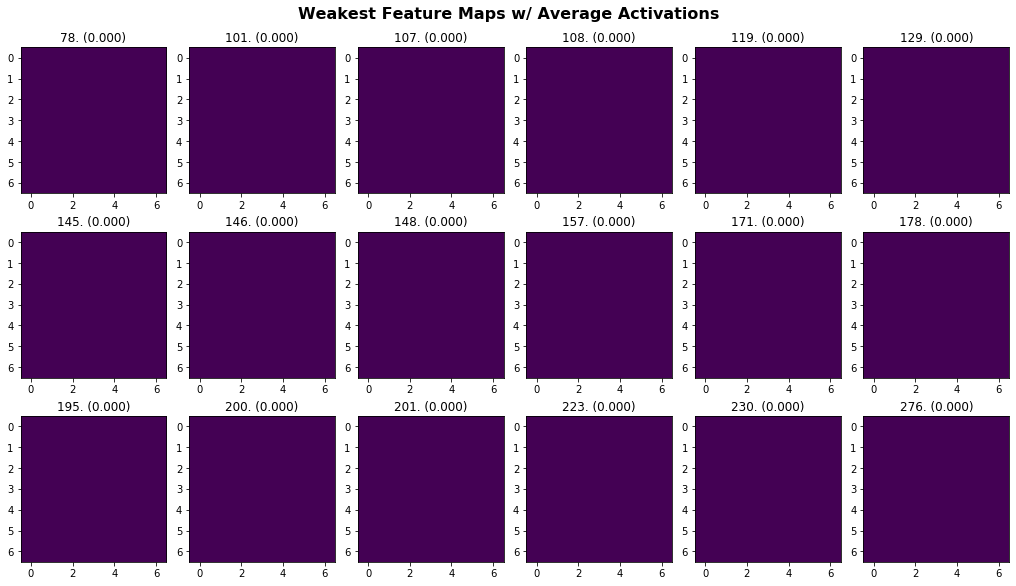

In [278]:
fig = mpl.figure.Figure(figsize=(14, 8), constrained_layout=True)
axes = fig.subplots(3, 6)
axes = axes.flatten()
top_maps = sorted(map_data, key=lambda d: d["value"], reverse=False)
for i, ax in enumerate(axes):
    ax.imshow(top_maps[i]["map"])
    ax.set_title("{}. ({:.3f})".format(top_maps[i]["index"], top_maps[i]["value"]))
fig.suptitle("Weakest Feature Maps w/ Average Activations", fontweight="bold", fontsize=16)
fig

### Most important featuremaps

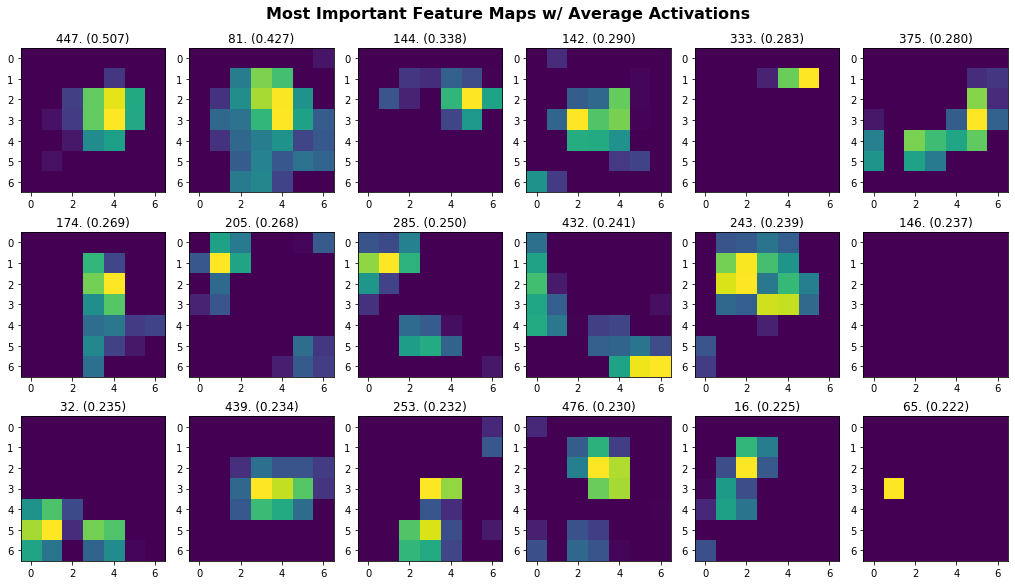

In [279]:
fig = mpl.figure.Figure(figsize=(14, 8), constrained_layout=True)
axes = fig.subplots(3, 6)
axes = axes.flatten()
top_maps = sorted(map_data, key=lambda d: d["weight"], reverse=True)
for i, ax in enumerate(axes):
    ax.imshow(top_maps[i]["map"])
    ax.set_title("{}. ({:.3f})".format(top_maps[i]["index"], top_maps[i]["weight"]))
fig.suptitle("Most Important Feature Maps w/ Average Activations", fontweight="bold", fontsize=16)
fig.savefig("[{}] Important Feature Maps.png".format(code0, dpi=320))
fig

### Distribution of Feature Values and Feature Weights

In [280]:
map_df = pd.DataFrame(map_data)
map_df["abs_weight"] = np.abs(map_df.weight)

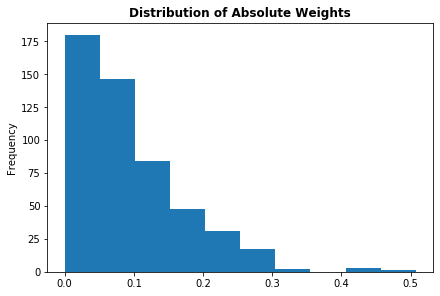

In [281]:
fig = mpl.figure.Figure(figsize=(6, 4), constrained_layout=True)
ax = fig.subplots()
map_df.abs_weight.plot.hist(ax=ax)
ax.set_title("Distribution of Absolute Weights", fontweight="bold")
fig.savefig("[{}] Weight Distribution.png".format(code0), dpi=320)
fig

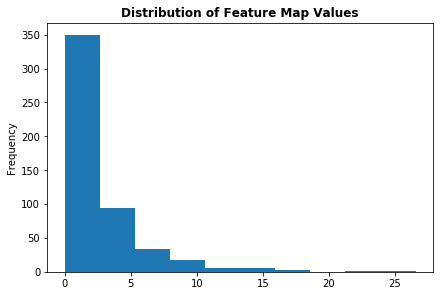

In [282]:
fig = mpl.figure.Figure(figsize=(6, 4), constrained_layout=True)
ax = fig.subplots()
map_df.value.plot.hist(ax=ax)
ax.set_title("Distribution of Feature Map Values", fontweight="bold")
fig.savefig("[{}] Feature Value Distribution.png".format(code0), dpi=320)
fig

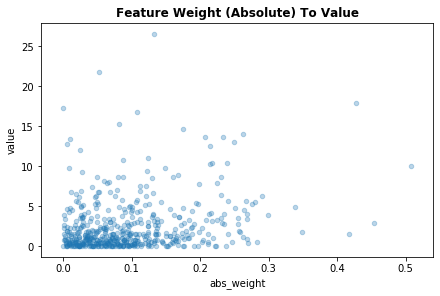

In [283]:
fig = mpl.figure.Figure(figsize=(6, 4), constrained_layout=True)
ax = fig.subplots()
map_df.plot.scatter("abs_weight", "value", alpha=0.3, ax=ax)
ax.set_title("Feature Weight (Absolute) To Value", fontweight="bold")
fig.savefig("[{}] Feature Weight To Value.png".format(code0), dpi=320)
fig

In [284]:
scores_pos = np.maximum(scores, np.zeros(*scores.shape))

In [285]:
map_list = []
weight_list = []
for i in range(3):
    m, w = get_feature_maps_and_weights(test_model.get_model(), preprocessed, i)
    m = np.mean(m, axis=(0, 1, 2))
    map_list.append(m)
    weight_list.append(w)

In [286]:
dot_list = []
for i in range(3):
    m, w = map_list[i], weight_list[i]
    dot = np.dot(m, w.T)
    dot_list.append(dot)